<a href="https://colab.research.google.com/github/wonjae124/Capston/blob/colab/pretraining_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install pytorch-tabnet

In [5]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=003b611f4d13ba32a5fec1f7028ce56198a80225848351e36a1455c7e0e64017
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [6]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [8]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [9]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [10]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [11]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [12]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

# Network parameters

In [13]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [16]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared=1, # nb shared glu for decoding
    n_independent=1, # nb independent glu for decoding
)

Device used : cpu


# Self Supervised Training

In [17]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [18]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
) 

epoch 0  | loss: 4.28436 | val_0_unsup_loss: 2.23234 |  0:00:01s
epoch 1  | loss: 1.42559 | val_0_unsup_loss: 1.2398  |  0:00:02s
epoch 2  | loss: 1.14108 | val_0_unsup_loss: 1.1325  |  0:00:03s
epoch 3  | loss: 1.09288 | val_0_unsup_loss: 1.11204 |  0:00:04s
epoch 4  | loss: 1.07248 | val_0_unsup_loss: 1.09493 |  0:00:05s
epoch 5  | loss: 1.06218 | val_0_unsup_loss: 1.0813  |  0:00:06s
epoch 6  | loss: 1.05196 | val_0_unsup_loss: 1.06179 |  0:00:07s
epoch 7  | loss: 1.04508 | val_0_unsup_loss: 1.03581 |  0:00:09s
epoch 8  | loss: 1.02715 | val_0_unsup_loss: 0.98683 |  0:00:10s
epoch 9  | loss: 1.01206 | val_0_unsup_loss: 0.9514  |  0:00:11s
epoch 10 | loss: 0.9954  | val_0_unsup_loss: 0.93361 |  0:00:12s
epoch 11 | loss: 0.97729 | val_0_unsup_loss: 0.91757 |  0:00:13s
epoch 12 | loss: 0.96394 | val_0_unsup_loss: 0.9064  |  0:00:14s
epoch 13 | loss: 0.95385 | val_0_unsup_loss: 0.89508 |  0:00:15s
epoch 14 | loss: 0.94914 | val_0_unsup_loss: 0.88513 |  0:00:17s
epoch 15 | loss: 0.94387 

In [19]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [20]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

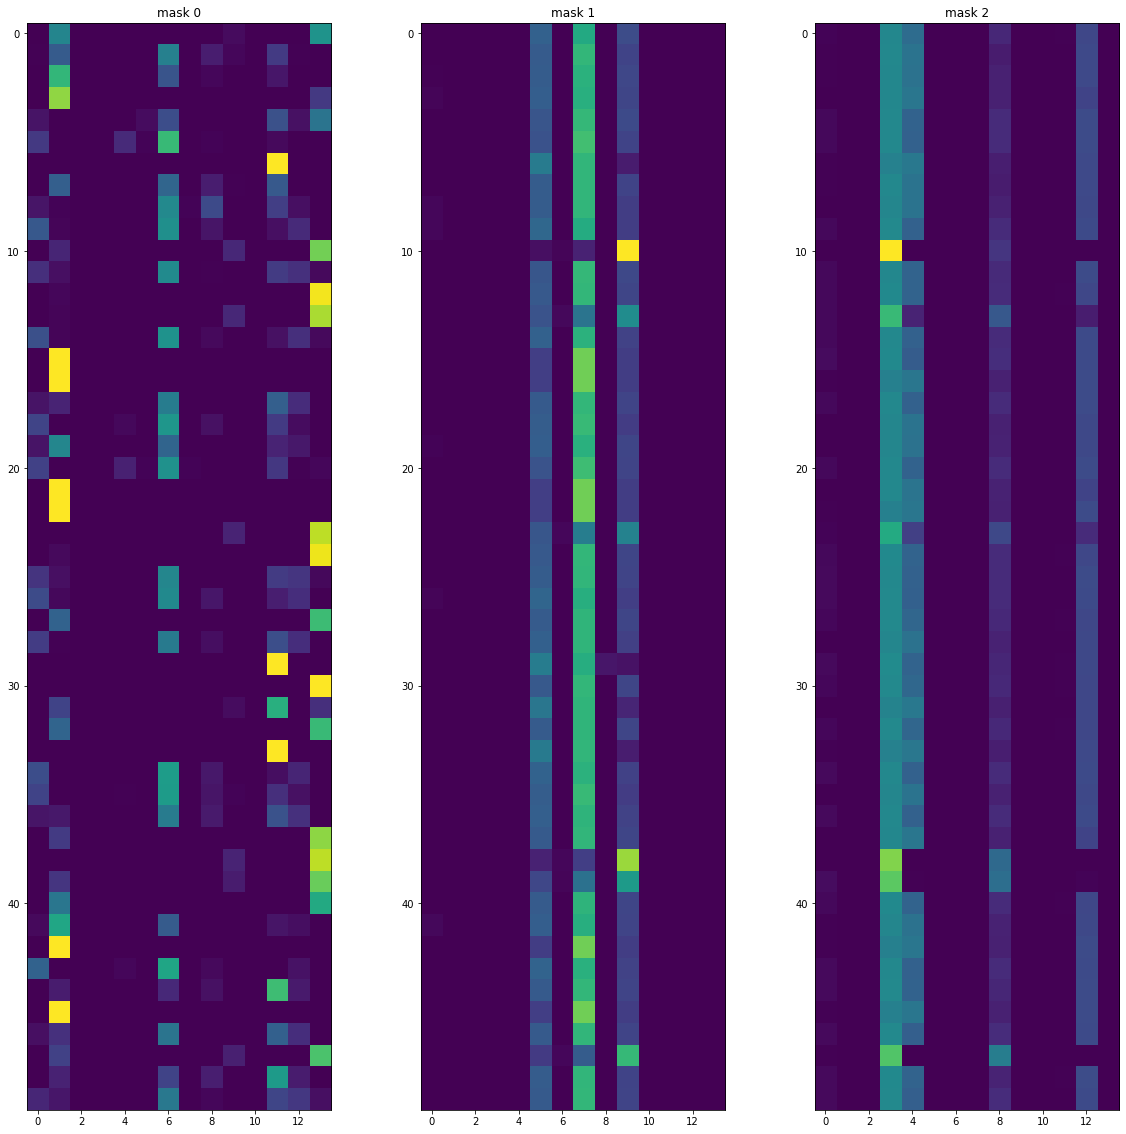

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


## Save and load the same way as other TabNet models

In [22]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip
Device used : cpu
Device used : cpu


# Training

In [23]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

Device used : cpu


In [44]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
    
) 

Loading weights from unsupervised pretraining
epoch 0  | loss: 0.50307 | train_logloss: 0.45736 | valid_logloss: 0.44994 |  0:00:01s
epoch 1  | loss: 0.40595 | train_logloss: 0.40714 | valid_logloss: 0.40405 |  0:00:03s
epoch 2  | loss: 0.38203 | train_logloss: 0.42778 | valid_logloss: 0.43236 |  0:00:05s
epoch 3  | loss: 0.36189 | train_logloss: 0.49302 | valid_logloss: 0.50739 |  0:00:06s
epoch 4  | loss: 0.34873 | train_logloss: 0.46402 | valid_logloss: 0.48035 |  0:00:08s
epoch 5  | loss: 0.33125 | train_logloss: 0.50839 | valid_logloss: 0.52778 |  0:00:09s
epoch 6  | loss: 0.327   | train_logloss: 0.51183 | valid_logloss: 0.53716 |  0:00:11s
epoch 7  | loss: 0.31775 | train_logloss: 0.38613 | valid_logloss: 0.40341 |  0:00:13s
epoch 8  | loss: 0.32284 | train_logloss: 0.37302 | valid_logloss: 0.39173 |  0:00:14s
epoch 9  | loss: 0.31515 | train_logloss: 0.35828 | valid_logloss: 0.37008 |  0:00:16s
epoch 10 | loss: 0.31451 | train_logloss: 0.31737 | valid_logloss: 0.33385 |  0:00:1

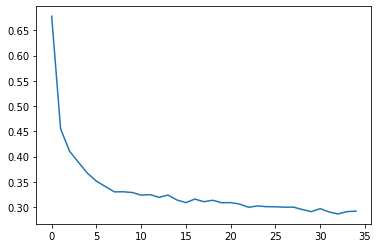

In [25]:
# plot losses
plt.plot(clf.history['loss'])

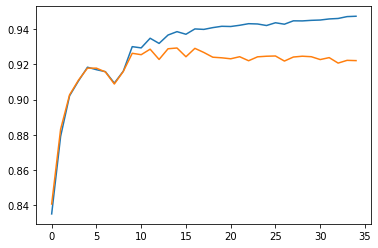

In [26]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

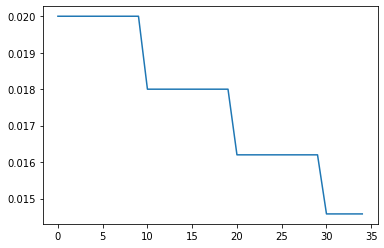

In [27]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [43]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9293231007890694
FINAL TEST SCORE FOR census-income : 0.9276145602837242


In [41]:
y_valid.shape

(3221,)

In [47]:
preds[:,-1].shape


(3267,)

In [29]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [31]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [32]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [33]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9314764184931752


In [34]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [35]:
clf.feature_importances_

array([8.00061614e-02, 1.72575376e-01, 2.51272900e-04, 2.17954454e-02,
       2.09166900e-01, 4.61596671e-02, 1.67994962e-01, 9.70298699e-02,
       2.94719545e-02, 1.08002755e-01, 1.33535531e-07, 5.82118374e-02,
       4.76607808e-06, 9.32889975e-03])

# Local explainability and masks

In [36]:
explain_matrix, masks = clf.explain(X_test)

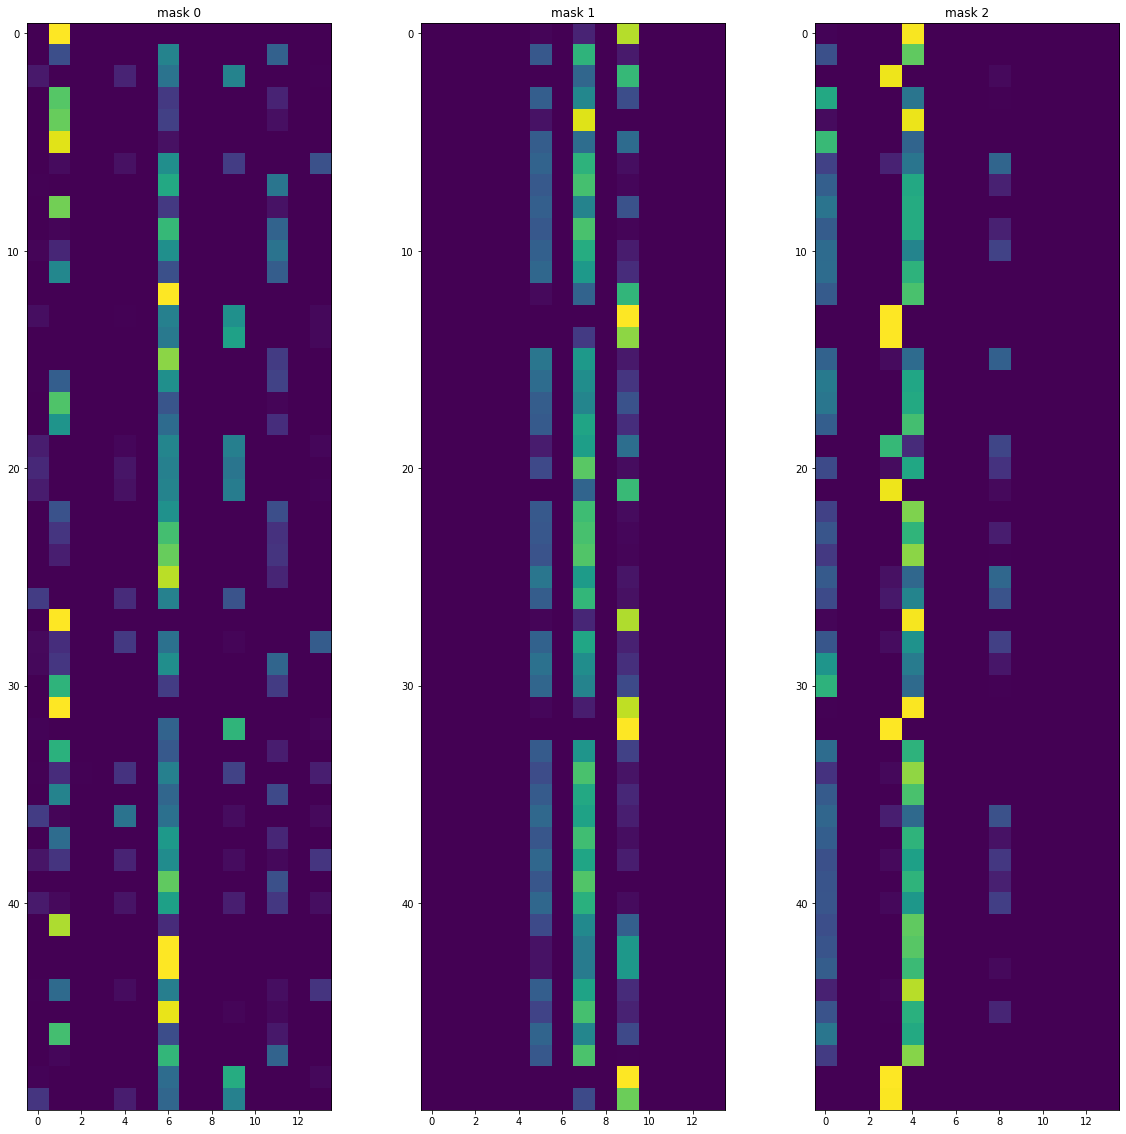

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
